In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from gensim.models import word2vec,KeyedVectors
import gensim.downloader as api

import torch
import torch.nn as nn
from torch.optim import SGD
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence


from transformers import AutoTokenizer,AutoModel,AutoModelForSequenceClassification
from transformers import BertTokenizer
from transformers import TrainingArguments,Trainer
from transformers import DataCollatorWithPadding
import evaluate
from datasets import load_dataset
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
device=torch.device('cpu')

In [88]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of GPUs
print(torch.cuda.get_device_name(0))  # GPU name

True
1
NVIDIA GeForce RTX 2080 Ti


In [3]:
wv_google_new=api.load('word2vec-google-news-300')

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/venky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess_text(text):
    #convert to text to lowercase
    text=text.lower()
    
    #remove emails
    text=re.sub(r"^\S+@\S+\.\S+$","",text)

    #remove special characters
    text=re.sub(r'[^A-Za-z0-9\s]',"",text)

    #remove any IP adderesses
    text=re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b',"",text)

    return text

def tokenize_text(text):
    #create tokrnizer instance
    tokenizer=get_tokenizer('basic_english')
    tokens=tokenizer(text)

    #remove any stopwords if any
    filtered_tokens=[token for token in tokens if token not in stopwords.words('english')]

    return filtered_tokens

#function to vectorize 
def vectorize_word2vec_pretrained(tokens):
    '''This function will use pretrained word to vec that is trained on google news.
       We will pass token by token to vectorize it, if some oov word is found we will ignore it for now'''

    vectorized_token=[wv_google_new[token] for token in tokens if token in wv_google_new]
    return vectorized_token
        


def split_train_test_val(data,col):
    '''This function will split the data into train,val and test sets and will stratify on the col column passed'''
    
    train_df,temp_df=train_test_split(data,test_size=0.30,random_state=42,stratify=data[col])
    val_df,test_df=train_test_split(temp_df,test_size=0.50,random_state=42,stratify=temp_df[col])

    train_df=train_df.reset_index(drop=True)
    val_df=val_df.reset_index(drop=True)
    test_df=test_df.reset_index(drop=True)

    return train_df,val_df,test_df
    

### Load the amazon reviews 

In [13]:
amazon_reviews=pd.read_csv('amazon_cells_labelled_LARGE_25K.txt',delimiter='\t',names=['Sentence','Class'],header=None)

In [14]:
amazon_reviews.head()

,Sentence,Class
0,"I've read this book with much expectation, it ...",0
1,love it...very touch.it's to bad that in the d...,1
2,The creepiest book I've ever read! It's a cree...,1
3,"It starts off a bit slow, but once the product...",1
4,"As good as this book may be, the print quality...",0


In [15]:
#preprocess the text
amazon_reviews['Sentence']=amazon_reviews['Sentence'].apply(lambda x:preprocess_text(x))

In [16]:
amazon_reviews.head()

,Sentence,Class
0,ive read this book with much expectation it wa...,0
1,love itvery touchits to bad that in the dvd de...,1
2,the creepiest book ive ever read its a creepy ...,1
3,it starts off a bit slow but once the product ...,1
4,as good as this book may be the print quality ...,0


In [17]:
amazon_reviews['Tokenized Text']=amazon_reviews['Sentence'].apply(lambda x: tokenize_text(x))

In [18]:
amazon_reviews.head()

,Sentence,Class,Tokenized Text
0,ive read this book with much expectation it wa...,0,"[ive, read, book, much, expectation, boring, b..."
1,love itvery touchits to bad that in the dvd de...,1,"[love, itvery, touchits, bad, dvd, description..."
2,the creepiest book ive ever read its a creepy ...,1,"[creepiest, book, ive, ever, read, creepy, mys..."
3,it starts off a bit slow but once the product ...,1,"[starts, bit, slow, product, placement, jokes,..."
4,as good as this book may be the print quality ...,0,"[good, book, may, print, quality, bad, cannot,..."


In [19]:
amazon_reviews['Vectorized Tokens Pretrained']=amazon_reviews['Tokenized Text'].apply(lambda x: vectorize_word2vec_pretrained(x))

In [20]:
amazon_reviews.head()

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained
0,ive read this book with much expectation it wa...,0,"[ive, read, book, much, expectation, boring, b...","[[-0.41210938, 0.18847656, -0.234375, 0.296875..."
1,love itvery touchits to bad that in the dvd de...,1,"[love, itvery, touchits, bad, dvd, description...","[[0.103027344, -0.15234375, 0.025878906, 0.165..."
2,the creepiest book ive ever read its a creepy ...,1,"[creepiest, book, ive, ever, read, creepy, mys...","[[-0.017822266, -0.12158203, 0.16601562, 0.104..."
3,it starts off a bit slow but once the product ...,1,"[starts, bit, slow, product, placement, jokes,...","[[0.049560547, 0.18261719, -0.18554688, 0.1074..."
4,as good as this book may be the print quality ...,0,"[good, book, may, print, quality, bad, cannot,...","[[0.040527344, 0.0625, -0.017456055, 0.0786132..."


In [21]:
train_df,val_df,test_df=split_train_test_val(amazon_reviews,'Class')

In [22]:
train_df.head()

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained
0,it looks great when you install it but it wont...,0,"[looks, great, install, wont, last, long, woul...","[[0.024047852, 0.31445312, -0.026245117, 0.071..."
1,this is another great transitional and educati...,1,"[another, great, transitional, educational, do...","[[0.19433594, -0.01965332, 0.091796875, 0.1044..."
2,just when you think oh great another zombie mo...,1,"[think, oh, great, another, zombie, movie, fid...","[[-0.046875, 0.06689453, 0.009338379, 0.263671..."
3,very goodthis kept me wanting more could not w...,0,"[goodthis, kept, wanting, could, wait, see, ha...","[[0.048828125, 0.084472656, -0.029052734, 0.07..."
4,i love this series i just cant get enough the ...,1,"[love, series, cant, get, enough, people, acti...","[[0.103027344, -0.15234375, 0.025878906, 0.165..."


#### Creating data classes and data loaders for the pretrained Word2Vec

In [12]:
'''
Here we will create a custom data class, which inherits from Dataset
'''

class Word2VecData(Dataset):
    def __init__(self,data,max_len=500):
        self.data=data.reset_index(drop=True)  #here we are initialising the data
        self.max_len=max_len  #here we are taking a max length, how many token we want to pass

    def __len__(self):
        return(len(self.data))  #return how many rows the dataframe has

    def __getitem__(self,idx):
        row=self.data.iloc[idx]

        features=row['Vectorized Tokens Pretrained']
        labels=row['Class']

        #before conversion, check if features are numpy array
        if isinstance(features,(list,np.array)):
            tensors=torch.FloatTensor(features)
        else:
            tensors=torch.FloatTensor([features])

        labels=torch.FloatTensor([labels])

        return tensors,labels



#create a collate function

def collate_fn(batch):
    sequences,labels=zip(*batch)
    lengths = torch.tensor([seq.size(0) for seq in sequences], dtype=torch.long)
    padded_sequence=pad_sequence(sequences,batch_first=True)
    labels=torch.stack(labels)

    return padded_sequence,labels,lengths



#create dataloaders
# train_loader=DataLoader(Word2VecData(train_df),batch_size=16,collate_fn=collate_fn,num_workers=0)
# val_loader=DataLoader(Word2VecData(val_df),batch_size=16,collate_fn=collate_fn)
# test_loader=DataLoader(Word2VecData(test_df),batch_size=16,collate_fn=collate_fn)

In [24]:
train_df

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained
0,it looks great when you install it but it wont...,0,"[looks, great, install, wont, last, long, woul...","[[0.024047852, 0.31445312, -0.026245117, 0.071..."
1,this is another great transitional and educati...,1,"[another, great, transitional, educational, do...","[[0.19433594, -0.01965332, 0.091796875, 0.1044..."
2,just when you think oh great another zombie mo...,1,"[think, oh, great, another, zombie, movie, fid...","[[-0.046875, 0.06689453, 0.009338379, 0.263671..."
3,very goodthis kept me wanting more could not w...,0,"[goodthis, kept, wanting, could, wait, see, ha...","[[0.048828125, 0.084472656, -0.029052734, 0.07..."
4,i love this series i just cant get enough the ...,1,"[love, series, cant, get, enough, people, acti...","[[0.103027344, -0.15234375, 0.025878906, 0.165..."
...,...,...,...,...
17495,didnt work right out of the box so i asked for...,0,"[didnt, work, right, box, asked, refund, leery...","[[-0.075683594, 0.033691406, -0.064941406, 0.1..."
17496,product was a gba charger not a ds charger the...,0,"[product, gba, charger, ds, charger, gba, char...","[[-0.061523438, 0.095214844, 0.13378906, 0.064..."
17497,this is one of the oldies but goodies i enjoye...,1,"[one, oldies, goodies, enjoyed, movie, child, ...","[[0.045654297, -0.14550781, 0.15625, 0.1660156..."
17498,if this book didnt have quotes it would be a p...,0,"[book, didnt, quotes, would, pamphlet, definit...","[[0.11279297, -0.026123047, -0.044921875, 0.06..."


### Create RNN Model

In [13]:
class WordToVecRNNPT(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(WordToVecRNNPT,self).__init__()
        self.rnn=nn.RNN(input_size,hidden_size)
        self.hidden_to_op=nn.Linear(hidden_size,output_size)
        self.sigmoid=nn.Sigmoid()

    def forward(self,tensors,length):
        '''we padded the sequences so that the input is of same shape, we need to unpack it so rnn learns from real input and not
        padded one'''

        pack_padded_tensors=pack_padded_sequence(tensors,length.cpu(),batch_first=True,enforce_sorted=False)
        rnn_out,hidden=self.rnn(pack_padded_tensors)
        output=self.hidden_to_op(hidden[-1])
        output=self.sigmoid(output)

        return output
        
    

In [14]:
#input size will number of dimension of vector
input_size=300
hidden_size=128 #we give it
output_size=1  #binary classification

word2vec_pt_model=WordToVecRNNPT(input_size,hidden_size,output_size)
print(word2vec_pt_model)

### Training


In [15]:
#define parameters for training
epochs=150
lr=1e-5
criterion=nn.BCELoss()




In [16]:
def train_network(model,train_loader,val_loader,epochs,lr,criterion):
    optimizer=SGD(model.parameters(),lr=lr)
    train_loss_epoch=[]
    val_loss_epoch=[]

    for i in range(epochs):
        
        curr_train_loss=0
        avg_train_loss=0
        curr_val_loss=0
        avg_val_loss=0

        for ix,train_data in enumerate(train_loader):
            
            inputs,labels,lengths=train_data
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            #set training mode
            model.train()

            #reset the gradients
            optimizer.zero_grad()

            #forward pass
            output=model(inputs,lengths)

            #calculate loss
            
            loss=criterion(output,labels)

            curr_train_loss+=loss.item()

            #compute gradient
            loss.backward()

            #update params
            optimizer.step()


        avg_train_loss=curr_train_loss/len(train_loader)
        

        with torch.no_grad():
            for idx,val_data in enumerate(val_loader):
                inputs,labels,lengths=val_data
                inputs = inputs.to(device)
                labels = labels.to(device)
                lengths = lengths.to(device)

                val_output=model(inputs,lengths)
                val_loss=criterion(val_output,labels)

                curr_val_loss+=val_loss.item()


            avg_val_loss=curr_val_loss/len(val_loader)

        train_loss_epoch.append(avg_train_loss)
        val_loss_epoch.append(avg_val_loss)

        if (i+1)%5==0:
            print(f"epoch {i+1}:  training loss : {avg_train_loss}, val loss: {avg_val_loss}")
              

In [17]:
## function to test our model
def test_model(model,test_loader):
    all_predictions=[]
    all_labels=[]
    
    model.eval()
    with torch.no_grad():
        for idx, test_data in enumerate(test_loader):
            inputs, labels,lengths=test_data

            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            

            outputs=model.forward(inputs,lengths)  #gives probablities 
            predictions=(outputs>0.5).float()

            labels=labels.float()  #ensure they are also float

            all_labels.append(labels.view(-1))
            all_predictions.append(predictions.view(-1))


        all_predictions=torch.cat(all_predictions,dim=0)
        all_labels=torch.cat(all_labels,dim=0)

        accuracy=(all_predictions==all_labels).float().mean()


        return accuracy.item()
            

            

            

            

            
            

        

In [31]:
#train the network
train_network(word2vec_pt_model,train_loader,val_loader,epochs,lr,criterion)

/var/folders/8v/d0lxwjpj4v527f9nxwhfz6m80000gn/T/ipykernel_40516/3378725027.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  tensors=torch.FloatTensor(features)


epoch 5:  training loss : 0.6936645545405923, val loss: 0.6930644631385803
epoch 10:  training loss : 0.6910569034721123, val loss: 0.6905001533792374
epoch 15:  training loss : 0.688707331471295, val loss: 0.6881897431738833
epoch 20:  training loss : 0.6865866309001197, val loss: 0.6861045365637921
epoch 25:  training loss : 0.6846698105771102, val loss: 0.6842199858198774
epoch 30:  training loss : 0.6829351796964405, val loss: 0.6825147377683761
epoch 35:  training loss : 0.6813638733880394, val loss: 0.6809702609447723
epoch 40:  training loss : 0.679939319326847, val loss: 0.6795702122627421
epoch 45:  training loss : 0.678646739647201, val loss: 0.6783000441307717
epoch 50:  training loss : 0.6774729965918679, val loss: 0.6771468213263978
epoch 55:  training loss : 0.6764063080551419, val loss: 0.6760989171393375
epoch 60:  training loss : 0.6754360090552998, val loss: 0.6751458259339028
epoch 65:  training loss : 0.6745525524428819, val loss: 0.6742781344880449
epoch 70:  train

In [33]:
rnn_test_acc=test_model(word2vec_pt_model,test_loader)
print(f"{rnn_test_acc:.2f}")

0.60


### Creating an LSTM model


In [18]:

class LSTMModel(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTMModel,self).__init__()

        self.LSTM=nn.LSTM(input_size,hidden_size,num_layers=1)
        self.output_layer=nn.Linear(hidden_size,output_size)
        self.sigmoid_layer=nn.Sigmoid()

    def forward(self,input_tensors,length):

        #pack padded sequence so that padded tokens does not go into the model
        packed_tensors=pack_padded_sequence(input_tensors,length.cpu(),enforce_sorted=False,batch_first=True)
        x,(h_n,c_n)=self.LSTM(packed_tensors)
        output=self.output_layer(h_n[-1])
        output=self.sigmoid_layer(output)
        return output
        

In [41]:
lstm_model=LSTMModel(input_size,hidden_size,output_size)
print(lstm_model)

LSTMModel(
  (LSTM): LSTM(300, 128)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)


In [42]:
#train the lstm model 
train_network(lstm_model,train_loader,val_loader,epochs,lr,criterion)


epoch 5:  training loss : 0.683785950516434, val loss: 0.6837001224781605
epoch 10:  training loss : 0.6832430493461149, val loss: 0.683159091371171
epoch 15:  training loss : 0.6827206838283504, val loss: 0.6826384805618448
epoch 20:  training loss : 0.6822179961248115, val loss: 0.6821374609115276
epoch 25:  training loss : 0.6817342518561501, val loss: 0.6816552725244076
epoch 30:  training loss : 0.6812686652653396, val loss: 0.6811911476419327
epoch 35:  training loss : 0.6808205084565353, val loss: 0.6807443588338
epoch 40:  training loss : 0.6803890882397047, val loss: 0.6803142101206678
epoch 45:  training loss : 0.6799737056495938, val loss: 0.6799000184586708
epoch 50:  training loss : 0.6795737334208689, val loss: 0.6795011560967628
epoch 55:  training loss : 0.6791885692959948, val loss: 0.6791170120239258
epoch 60:  training loss : 0.6788176134691813, val loss: 0.6787469934909902
epoch 65:  training loss : 0.6784603073784377, val loss: 0.6783905574615966
epoch 70:  trainin

#### Testing out LSTM model

In [43]:
test_acc=test_model(lstm_model,test_loader)

In [44]:
print(f"{test_acc: .2f}")

 0.60


### Building a GRU Model

In [19]:
class GRUModel(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(GRUModel,self).__init__()

        #GRU layer
        self.GRU=nn.GRU(input_size,hidden_size,num_layers=1)
        self.output_layer=nn.Linear(hidden_size,output_size)
        self.sigmoid_layer=nn.Sigmoid()

    def forward(self,input_tensors,length):
        packed_tensors=pack_padded_sequence(input_tensors,length.cpu(),batch_first=True,enforce_sorted=False)

        op,hidden=self.GRU(packed_tensors)
        output=self.output_layer(hidden[-1])
        output=self.sigmoid_layer(output)

        return output

In [99]:
#create an instnace of the model
gru_model=GRUModel(input_size,hidden_size,output_size)


#train the model
train_network(gru_model,train_loader,val_loader,epochs,lr,criterion)

epoch 5:  training loss : 0.6576787329787964, val loss: 0.6560546451426567
epoch 10:  training loss : 0.6448155138130816, val loss: 0.6421988010406494
epoch 15:  training loss : 0.625260347830748, val loss: 0.6209359014287908
epoch 20:  training loss : 0.5937525889609806, val loss: 0.586508390497654
epoch 25:  training loss : 0.5385269783369148, val loss: 0.5257469597014975
epoch 30:  training loss : 0.44376516852943293, val loss: 0.43049704692465196
epoch 35:  training loss : 0.4044157382802292, val loss: 0.39969099880533016
epoch 40:  training loss : 0.3947364233665754, val loss: 0.3911111587856678
epoch 45:  training loss : 0.38898592940795573, val loss: 0.38610516631222785
epoch 50:  training loss : 0.38501914937927695, val loss: 0.3827920995494153
epoch 55:  training loss : 0.3820755751071399, val loss: 0.38043162401052233
epoch 60:  training loss : 0.37977183099420675, val loss: 0.37866233374844205
epoch 65:  training loss : 0.377898078520784, val loss: 0.37729008194613967
epoch 

In [102]:
gru_test_acc=test_model(gru_model,test_loader)
print(f"{gru_test_acc:.2f}")

0.83


In [5]:
### wandb login
# !pip3 install wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: venky_ai (venky_ai-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Hugging Face Transformers

Here we will use different pre trained models from hugging face

In [6]:
def tokenize_using_hf(text,tokenizer):
    '''This function will tokenize the text using the particular 
       tokenizer from hugging face'''

    tokenized_text=tokenizer(text,
                            padding='max_length', #padding the tokens so al inputs are of same length
                            truncation=True,
                            max_length=500,
                            return_tensors='pt')   #returns a dictionary
    return (tokenized_text['input_ids'].squeeze(),tokenized_text['attention_mask'].squeeze())

    

recall=evaluate.load('recall')
precision=evaluate.load('precision')
f1_score=evaluate.load('f1')
accuracy=evaluate.load('accuracy')
    
def eval_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)  # For classification

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"]
        # "f1": f1_score.compute(predictions=predictions, references=labels)["f1"],
        # "precision": precision.compute(predictions=predictions, references=labels)["precision"],
        # "recall": recall.compute(predictions=predictions, references=labels)["recall"]
    }
    
    


def create_model(model,num_labels): 
    model=AutoModelForSequenceClassification.from_pretrained(model,num_labels=num_labels) 
    return model


# def train_model(tokenizer,model,train_data,val_data,learning_rate,epochs,run_name,data_collator):
#     print("setting training arguments")
#     training_arguments=TrainingArguments(per_device_train_batch_size=4,  #reduce batch size to prevent overfitting, just a try
#                                          per_device_eval_batch_size=4,
#                                          learning_rate=learning_rate,
#                                          weight_decay=0.01,  #since for next dataset we have hige amout of data else keep it 0.2/0.5
#                                         num_train_epochs=epochs,
#                                         report_to='wandb',
#                                         run_name=run_name,
#                                         output_dir='./results',  #maybe this helps to log in wandb
#                                         eval_strategy='epoch',
#                                         logging_strategy='epoch',
#                                         logging_dir='./logs',
#                                         push_to_hub=True,
#                                         hub_model_id="Venky19/Bert_for_sentiment_analysis_lab")

def train_model(tokenizer,model,train_data,val_data,learning_rate,epochs,run_name,data_collator):  
    print("setting training arguments")
    training_arguments=TrainingArguments(per_device_train_batch_size=4,  #batch size is 4 for smaller dataset, 32 for larger one
                                         per_device_eval_batch_size=4,
                                         #gradient_accumulation_steps=2, 
                                         fp16=True,
                                         learning_rate=learning_rate,
                                         weight_decay=0.02,  #since for next dataset we have hige amout of data else keep it 0.2/0.5
                                         num_train_epochs=epochs,
                                         report_to='wandb',
                                         run_name=run_name,
                                        output_dir='./small_data/results',  #maybe this helps to log in wandb
                                        eval_strategy='epoch',
                                        logging_strategy='epoch',
                                        logging_dir='./small_data/logs',
                                        save_strategy='epoch',
                                        load_best_model_at_end=True, 
                                        metric_for_best_model="eval_loss",
                                        greater_is_better=False)
                                        #remove_unused_columns=False) 
                                        # push_to_hub=True,
                                        # hub_model_id="Venky19/Bert_for_sentiment_analysis_lab")    
    print("Setting up the trainer....")

    print("move to cuda")
    model.to("cuda")
    model_is_on_cuda = next(model.parameters()).is_cuda
    print(model_is_on_cuda)

    wandb.init(project="lab1_Sentiment analysis small dataset", name=run_name)  #project name 
    wandb.config.update({
    "learning_rate":learning_rate,
    "epochs":epochs,
    "model":model,
    "batch_size":4})  #batch size 4 for smaller size, 32 for large


    trainer=Trainer(model=model,
                    args=training_arguments,
                    train_dataset=train_data,
                    eval_dataset=val_data,
                    tokenizer=tokenizer,
                    compute_metrics=eval_metrics,
                    data_collator=data_collator) #removed data collator
                    

    print("Training started")
    
    trainer.train()
    
    res=trainer.evaluate()

    return trainer,res
    



                                         

In [74]:
acc_dict={"Model":[],
          "Accuracy":[]}

In [14]:
### Create a custom data class
class HuggingFaceDataset(Dataset):
    def __init__(self,input_ids,attention_mask,labels):
        self.input_ids=input_ids
        self.attention_mask=attention_mask
        self.labels=labels.tolist() if hasattr(labels,'tolist') else labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            return {
                'input_ids': [self.input_ids[i] for i in idx],
                'attention_mask': [self.attention_mask[i] for i in idx],
                'labels': torch.tensor([self.labels[i] for i in idx], dtype=torch.long)
            }
        return {
            'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx],dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

#### Bert Model

In [37]:
bert_tokenizer=AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

#tokenize train_df
train_df['Bert Tokenizer']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[0])
train_df['Bert Attention_Mask']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[1])

#tokenize val_df
val_df['Bert Tokenizer']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[0])
val_df['Bert Attention_Mask']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[1])

#create bert model
bert_model=create_model('google-bert/bert-base-uncased',num_labels=2)

#we will create the class of our dataset
bert_train_df=HuggingFaceDataset(train_df['Bert Tokenizer'],train_df['Bert Attention_Mask'],train_df['Class'])
bert_val_df=HuggingFaceDataset(val_df['Bert Tokenizer'],val_df['Bert Attention_Mask'],val_df['Class'])




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
bert_model.config.num_labels

2

In [61]:
bert_trainer,bert_res=train_model(bert_tokenizer,bert_model,bert_train_df,bert_val_df,learning_rate=lr,epochs=10,run_name="Bert Model")

setting training arguments
Setting up the trainer....
move to cuda
True


/tmp/ipykernel_9104/2092782252.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Training started


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.264700,0.369842,0.918667,0.934196,0.914660,0.954586
2,0.150300,0.446230,0.925067,0.938820,0.927312,0.950617
3,0.093600,0.443489,0.924267,0.938767,0.918565,0.959877
4,0.054400,0.633386,0.922133,0.934470,0.951554,0.917989
5,0.032800,0.641733,0.926933,0.940409,0.927897,0.953263
6,0.015900,0.672033,0.925600,0.938151,0.943379,0.932981
7,0.012200,0.796337,0.924533,0.936760,0.949705,0.924162
8,0.007700,0.765888,0.928533,0.941382,0.934028,0.948854
9,0.007300,0.787075,0.928000,0.940186,0.944791,0.935626
10,0.005000,0.782092,0.928267,0.940579,0.942452,0.938713


In [62]:
bert_res

{'eval_loss': 0.36984163522720337,
 'eval_accuracy': 0.9186666666666666,
 'eval_f1': 0.9341963322545846,
 'eval_precision': 0.9146599070553443,
 'eval_recall': 0.9545855379188712,
 'eval_runtime': 16.8399,
 'eval_samples_per_second': 222.685,
 'eval_steps_per_second': 55.701,
 'epoch': 10.0}

In [63]:
#tokenize test data
test_df['Bert Tokenizer']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[0])
test_df['Bert Attention_Mask']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[1])


bert_test_df=HuggingFaceDataset(test_df['Bert Tokenizer'],test_df['Bert Attention_Mask'],test_df['Class'])

In [65]:
bert_test_res=bert_trainer.evaluate(bert_test_df)

In [68]:
bert_test_res

{'eval_loss': 0.39687129855155945,
 'eval_accuracy': 0.9162666666666667,
 'eval_f1': 0.9325601374570447,
 'eval_precision': 0.9087484303055672,
 'eval_recall': 0.9576532862814292,
 'eval_runtime': 18.8973,
 'eval_samples_per_second': 198.441,
 'eval_steps_per_second': 49.637,
 'epoch': 10.0}

In [76]:
acc_dict['Model'].append("Bert")
acc_dict['Accuracy'].append(bert_test_res['eval_accuracy'])

In [67]:
with open('./bert_res_dict.txt',"w") as f:
    for key, value in bert_test_res.items():
        f.write(f"{key}: {value}\n")

#### Roberta

In [78]:
#load tokenizer
roberta_tokenizer=AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

##tokenize train_df
train_df['Roberta Tokenizer']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[0])
train_df['Roberta Attention_Mask']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[1])

#tokenize val_df
val_df['Roberta Tokenizer']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[0])
val_df['Roberta Attention_Mask']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[1])


#create roberta model
roberta_model=create_model('FacebookAI/roberta-base',num_labels=2)


#create the class of our dataset
roberta_train_df=HuggingFaceDataset(train_df['Roberta Tokenizer'],train_df['Roberta Attention_Mask'],train_df['Class'])
roberta_val_df=HuggingFaceDataset(val_df['Roberta Tokenizer'],val_df['Roberta Attention_Mask'],val_df['Class'])


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
#train the model
roberta_trainer,roberta_res=train_model(roberta_tokenizer,roberta_model,roberta_train_df,roberta_val_df,lr,epochs=10)
#removed parameter run name as already rep to wandb

setting training arguments
Setting up the trainer....
move to cuda
True
Training started


/tmp/ipykernel_9104/4213672134.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.374900,0.384194,0.926933,0.941503,0.912666,0.972222
2,0.237300,0.344738,0.943733,0.953411,0.954887,0.951940
3,0.148400,0.398546,0.934933,0.946042,0.948980,0.943122
4,0.109900,0.439301,0.940000,0.950078,0.956230,0.944004
5,0.067900,0.431416,0.943733,0.953205,0.958947,0.947531
6,0.051000,0.472982,0.939733,0.950976,0.935952,0.966490
7,0.043200,0.473464,0.940800,0.950928,0.953457,0.948413
8,0.027700,0.471903,0.942933,0.953029,0.948864,0.957231
9,0.016100,0.544222,0.941600,0.952131,0.944083,0.960317
10,0.010100,0.534662,0.942667,0.952820,0.948449,0.957231


In [82]:
roberta_res

{'eval_loss': 0.34473755955696106,
 'eval_accuracy': 0.9437333333333333,
 'eval_f1': 0.953411349083683,
 'eval_precision': 0.9548872180451128,
 'eval_recall': 0.9519400352733686,
 'eval_runtime': 17.3227,
 'eval_samples_per_second': 216.479,
 'eval_steps_per_second': 54.149,
 'epoch': 10.0}

In [83]:
#test the model here

#tokenize test data
test_df['Roberta Tokenizer']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[0])
test_df['Roberta Attention_Mask']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[1])


roberta_test_df=HuggingFaceDataset(test_df['Roberta Tokenizer'],test_df['Roberta Attention_Mask'],test_df['Class'])

roberta_test_res=roberta_trainer.evaluate(roberta_test_df)

In [85]:
acc_dict['Model'].append("Roberta")
acc_dict['Accuracy'].append(roberta_test_res['eval_accuracy'])

#### XLNet Model

In [88]:
#load tokenizer
xlnet_tokenizer=AutoTokenizer.from_pretrained('xlnet/xlnet-base-cased')

##tokenize train_df
train_df['XLNet Tokenizer']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[0])
train_df['XLNet Attention_Mask']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[1])

#tokenize val_df
val_df['XLNet Tokenizer']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[0])
val_df['XLNet Attention_Mask']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[1])


#create roberta model
xlnet_model=create_model('xlnet/xlnet-base-cased',num_labels=2)


#create the class of our dataset
xlnet_train_df=HuggingFaceDataset(train_df['XLNet Tokenizer'],train_df['XLNet Attention_Mask'],train_df['Class'])
xlnet_val_df=HuggingFaceDataset(val_df['XLNet Tokenizer'],val_df['XLNet Attention_Mask'],val_df['Class'])


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [72]:
train_df.head()

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained,Bert Tokenizer,Bert Attention_Mask,Roberta Tokenizer,Roberta Attention_Mask,XLNet Tokenizer,XLNet Attention_Mask
0,it looks great when you install it but it wont...,0,"[looks, great, install, wont, last, long, woul...","[[0.024047852, 0.31445312, -0.026245117, 0.071...","[tensor(101), tensor(2009), tensor(3504), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(405), tensor(1326), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
1,this is another great transitional and educati...,1,"[another, great, transitional, educational, do...","[[0.19433594, -0.01965332, 0.091796875, 0.1044...","[tensor(101), tensor(2023), tensor(2003), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(9226), tensor(16), tensor(2...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
2,just when you think oh great another zombie mo...,1,"[think, oh, great, another, zombie, movie, fid...","[[-0.046875, 0.06689453, 0.009338379, 0.263671...","[tensor(101), tensor(2074), tensor(2043), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(8987), tensor(77), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
3,very goodthis kept me wanting more could not w...,0,"[goodthis, kept, wanting, could, wait, see, ha...","[[0.048828125, 0.084472656, -0.029052734, 0.07...","[tensor(101), tensor(2200), tensor(2204), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(5525), tensor(205), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
4,i love this series i just cant get enough the ...,1,"[love, series, cant, get, enough, people, acti...","[[0.103027344, -0.15234375, 0.025878906, 0.165...","[tensor(101), tensor(1045), tensor(2293), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(118), tensor(657), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."


In [89]:
xlnet_trainer,xlnet_res=train_model(xlnet_tokenizer,xlnet_model,xlnet_train_df,xlnet_val_df,learning_rate=lr,epochs=10)

setting training arguments
Setting up the trainer....
move to cuda
True
Training started


/tmp/ipykernel_9104/4213672134.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.395400,0.421688,0.926400,0.940950,0.913965,0.969577
2,0.262700,0.363595,0.935467,0.946341,0.951829,0.940917
3,0.176000,0.361289,0.934400,0.946288,0.937284,0.955467
4,0.110500,0.483797,0.924800,0.935792,0.967514,0.906085
5,0.082300,0.544247,0.934400,0.945958,0.942644,0.949295
6,0.055500,0.549074,0.933067,0.945730,0.927874,0.964286
7,0.029600,0.591051,0.935200,0.946417,0.946625,0.946208
8,0.020300,0.669135,0.934933,0.946655,0.938855,0.954586
9,0.012200,0.661072,0.934933,0.946585,0.940000,0.953263
10,0.008200,0.693527,0.934667,0.946448,0.938448,0.954586


In [91]:
xlnet_res

{'eval_loss': 0.3612889349460602,
 'eval_accuracy': 0.9344,
 'eval_f1': 0.9462882096069869,
 'eval_precision': 0.9372837370242214,
 'eval_recall': 0.9554673721340388,
 'eval_runtime': 103.2542,
 'eval_samples_per_second': 36.318,
 'eval_steps_per_second': 9.084,
 'epoch': 10.0}

In [92]:
#test xlnst

test_df['XLNET Tokenizer']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[0])
test_df['XLNET Attention_Mask']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[1])


xlnet_test_df=HuggingFaceDataset(test_df['XLNET Tokenizer'],test_df['XLNET Attention_Mask'],test_df['Class'])

xlnet_test_res=xlnet_trainer.evaluate(xlnet_test_df)

In [94]:
acc_dict['Model'].append("XLNET")
acc_dict['Accuracy'].append(xlnet_test_res['eval_accuracy'])

#### ALBERT Model

In [96]:
#load tokenizer
albert_tokenizer=AutoTokenizer.from_pretrained('albert-base-v2')

#tokenize train df
train_df['Albert Tokenizer']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[0])
train_df['Albert Attention_Mask']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[1])

#tokenize val_df
val_df['Albert Tokenizer']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[0])
val_df['Albert Attention_Mask']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[1])


#create roberta model
albert_model=create_model('albert-base-v2',num_labels=2)


#create the class of our dataset
albert_train_df=HuggingFaceDataset(train_df['Albert Tokenizer'],train_df['Albert Attention_Mask'],train_df['Class'])
albert_val_df=HuggingFaceDataset(val_df['Albert Tokenizer'],val_df['Albert Attention_Mask'],val_df['Class'])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
train_df.head()

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained,Bert Tokenizer,Bert Attention_Mask,Roberta Tokenizer,Roberta Attention_Mask,XLNet Tokenizer,XLNet Attention_Mask,Albert Tokenizer,Albert Attention_Mask
0,it looks great when you install it but it wont...,0,"[looks, great, install, wont, last, long, woul...","[[0.024047852, 0.31445312, -0.026245117, 0.071...","[tensor(101), tensor(2009), tensor(3504), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(405), tensor(1326), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(32), tensor(1879), tensor(3...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,this is another great transitional and educati...,1,"[another, great, transitional, educational, do...","[[0.19433594, -0.01965332, 0.091796875, 0.1044...","[tensor(101), tensor(2023), tensor(2003), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(9226), tensor(16), tensor(2...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(48), tensor(25), tensor(226...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,just when you think oh great another zombie mo...,1,"[think, oh, great, another, zombie, movie, fid...","[[-0.046875, 0.06689453, 0.009338379, 0.263671...","[tensor(101), tensor(2074), tensor(2043), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(8987), tensor(77), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(114), tensor(76), tensor(42...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,very goodthis kept me wanting more could not w...,0,"[goodthis, kept, wanting, could, wait, see, ha...","[[0.048828125, 0.084472656, -0.029052734, 0.07...","[tensor(101), tensor(2200), tensor(2204), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(5525), tensor(205), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(253), tensor(254), tensor(1...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,i love this series i just cant get enough the ...,1,"[love, series, cant, get, enough, people, acti...","[[0.103027344, -0.15234375, 0.025878906, 0.165...","[tensor(101), tensor(1045), tensor(2293), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(118), tensor(657), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(31), tensor(339), tensor(48...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [97]:
#train the model
albert_outputs=train_model(albert_tokenizer,albert_model,albert_train_df,albert_val_df,lr,epochs=10)

setting training arguments
Setting up the trainer....
move to cuda
True
Training started


/tmp/ipykernel_9104/4213672134.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.445200,0.370251,0.927733,0.941278,0.925437,0.957672
2,0.312100,0.425010,0.924267,0.936776,0.946043,0.927690
3,0.210800,0.400764,0.926933,0.939327,0.943505,0.935185
4,0.127200,0.525242,0.929600,0.941019,0.953804,0.928571
5,0.075500,0.565172,0.930667,0.942605,0.943855,0.941358
6,0.044800,0.669188,0.927733,0.940348,0.938901,0.941799
7,0.024500,0.713279,0.926933,0.939273,0.944296,0.934303
8,0.005500,0.834169,0.926133,0.939081,0.936814,0.941358
9,0.005000,0.832910,0.927200,0.940536,0.929402,0.951940
10,0.001000,0.822708,0.927733,0.940479,0.936980,0.944004


In [98]:
albert_trainer=albert_outputs[0]



In [99]:
#test albert

test_df['Albert Tokenizer']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[0])
test_df['Albert Attention_Mask']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[1])


albert_test_df=HuggingFaceDataset(test_df['Albert Tokenizer'],test_df['Albert Attention_Mask'],test_df['Class'])

albert_test_res=albert_trainer.evaluate(albert_test_df)

In [101]:
acc_dict['Model'].append("Albert")
acc_dict['Accuracy'].append(albert_test_res['eval_accuracy'])

#### DistillBert 

In [102]:
#load tokenizer
distilbert_tokenizer=AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

#tokenize traindf
train_df['DistilBert Tokenizer']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[0])
train_df['DistilBert Attention_Mask']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[1])

#tokenize valdf
val_df['DistilBert Tokenizer']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[0])
val_df['DistilBert Attention_Mask']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[1])



#create model
distilbert_model=create_model('distilbert/distilbert-base-uncased',num_labels=2)

#create instance from data classes
distilbert_train_df=HuggingFaceDataset(train_df['DistilBert Tokenizer'],train_df['DistilBert Attention_Mask'],train_df['Class'])
distilbert_val_df=HuggingFaceDataset(val_df['DistilBert Tokenizer'],val_df['DistilBert Attention_Mask'],val_df['Class'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
train_df.head()

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained,Bert Tokenizer,Bert Attention_Mask,Roberta Tokenizer,Roberta Attention_Mask,XLNet Tokenizer,XLNet Attention_Mask,Albert Tokenizer,Albert Attention_Mask,DistilBert Tokenizer,DistilBert Attention_Mask
0,it looks great when you install it but it wont...,0,"[looks, great, install, wont, last, long, woul...","[[0.024047852, 0.31445312, -0.026245117, 0.071...","[tensor(101), tensor(2009), tensor(3504), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(405), tensor(1326), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(32), tensor(1879), tensor(3...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2009), tensor(3504), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,this is another great transitional and educati...,1,"[another, great, transitional, educational, do...","[[0.19433594, -0.01965332, 0.091796875, 0.1044...","[tensor(101), tensor(2023), tensor(2003), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(9226), tensor(16), tensor(2...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(48), tensor(25), tensor(226...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2023), tensor(2003), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,just when you think oh great another zombie mo...,1,"[think, oh, great, another, zombie, movie, fid...","[[-0.046875, 0.06689453, 0.009338379, 0.263671...","[tensor(101), tensor(2074), tensor(2043), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(8987), tensor(77), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(114), tensor(76), tensor(42...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2074), tensor(2043), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,very goodthis kept me wanting more could not w...,0,"[goodthis, kept, wanting, could, wait, see, ha...","[[0.048828125, 0.084472656, -0.029052734, 0.07...","[tensor(101), tensor(2200), tensor(2204), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(5525), tensor(205), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(253), tensor(254), tensor(1...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2200), tensor(2204), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,i love this series i just cant get enough the ...,1,"[love, series, cant, get, enough, people, acti...","[[0.103027344, -0.15234375, 0.025878906, 0.165...","[tensor(101), tensor(1045), tensor(2293), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(118), tensor(657), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(31), tensor(339), tensor(48...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(1045), tensor(2293), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [103]:
#strat training
distilbert_outputs=train_model(distilbert_tokenizer,distilbert_model,distilbert_train_df,distilbert_val_df,learning_rate=lr,epochs=10)

setting training arguments
Setting up the trainer....
move to cuda
True
Training started


/tmp/ipykernel_9104/4213672134.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.362400,0.323119,0.918933,0.933884,0.921459,0.946649
2,0.242500,0.366971,0.923200,0.935972,0.943946,0.928131
3,0.149600,0.424087,0.920533,0.934361,0.933539,0.935185
4,0.091200,0.630108,0.911200,0.924541,0.951049,0.899471
5,0.064600,0.557188,0.922400,0.936670,0.924796,0.948854
6,0.033400,0.685152,0.921600,0.935864,0.926166,0.945767
7,0.022700,0.774625,0.916000,0.930109,0.936132,0.924162
8,0.010900,0.838809,0.917067,0.931422,0.931628,0.931217
9,0.005400,0.899254,0.920267,0.934213,0.932367,0.936067
10,0.004900,0.905294,0.921333,0.935008,0.934390,0.935626


In [104]:
distilbert_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [107]:
#test the model

distilbert_trainer=distilbert_outputs[0]

test_df['DistilBert Tokenizer']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[0])
test_df['DistilBert Attention_Mask']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[1])


distilbert_test_df=HuggingFaceDataset(test_df['DistilBert Tokenizer'],test_df['DistilBert Attention_Mask'],test_df['Class'])

distilbert_test_res=distilbert_trainer.evaluate(distilbert_test_df)


In [109]:
acc_dict['Model'].append("DistilBert")
acc_dict['Accuracy'].append(distilbert_test_res['eval_accuracy'])

#### Electra

In [12]:
#tokenizer
electra_tokenizer=AutoTokenizer.from_pretrained('google/electra-base-discriminator')

#tokenize train df
train_df['Electra Tokenizer']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,electra_tokenizer)[0])
train_df['Electra Attention_Mask']=train_df['Sentence'].apply(lambda x: tokenize_using_hf(x,electra_tokenizer)[1])


#tokeize val df
val_df['Electra Tokenizer']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,electra_tokenizer)[0])
val_df['Electra Attention_Mask']=val_df['Sentence'].apply(lambda x: tokenize_using_hf(x,electra_tokenizer)[1])   


#create model
electra_model=create_model('google/electra-base-discriminator',num_labels=2)

#create instances of dataclass
electra_train_df=HuggingFaceDataset(train_df['Electra Tokenizer'],train_df['Electra Attention_Mask'],train_df['Class'])
electra_val_df=HuggingFaceDataset(val_df['Electra Tokenizer'],val_df['Electra Attention_Mask'],val_df['Class'])


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [93]:
train_df.head()

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained,Bert Tokenizer,Bert Attention_Mask,Roberta Tokenizer,Roberta Attention_Mask,XLNet Tokenizer,XLNet Attention_Mask,Albert Tokenizer,Albert Attention_Mask,DistilBert Tokenizer,DistilBert Attention_Mask,Electra Tokenizer,Electra Attention_Mask
0,it looks great when you install it but it wont...,0,"[looks, great, install, wont, last, long, woul...","[[0.024047852, 0.31445312, -0.026245117, 0.071...","[tensor(101), tensor(2009), tensor(3504), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(405), tensor(1326), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(32), tensor(1879), tensor(3...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2009), tensor(3504), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2009), tensor(3504), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,this is another great transitional and educati...,1,"[another, great, transitional, educational, do...","[[0.19433594, -0.01965332, 0.091796875, 0.1044...","[tensor(101), tensor(2023), tensor(2003), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(9226), tensor(16), tensor(2...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(48), tensor(25), tensor(226...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2023), tensor(2003), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2023), tensor(2003), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,just when you think oh great another zombie mo...,1,"[think, oh, great, another, zombie, movie, fid...","[[-0.046875, 0.06689453, 0.009338379, 0.263671...","[tensor(101), tensor(2074), tensor(2043), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(8987), tensor(77), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(114), tensor(76), tensor(42...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2074), tensor(2043), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2074), tensor(2043), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,very goodthis kept me wanting more could not w...,0,"[goodthis, kept, wanting, could, wait, see, ha...","[[0.048828125, 0.084472656, -0.029052734, 0.07...","[tensor(101), tensor(2200), tensor(2204), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(5525), tensor(205), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(253), tensor(254), tensor(1...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2200), tensor(2204), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(101), tensor(2200), tensor(2204), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,i love this series i just cant get enough the ...,1,"[love, series, cant, get, enough, people, acti...","[[0.103027344, -0.15234375, 0.025878906, 0.165...","[tensor(101), tensor(1045), tensor(2293), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(0), tensor(118), tensor(657), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5), tensor(5), tensor(5), tensor(5), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(2), tensor(31), tensor(339), tensor(48...","[tensor(1), tensor(1), tensor(1), tensor(1), t...

In [13]:
#train model
electra_trainer,electra_res=train_model(electra_tokenizer,electra_model,electra_train_df,electra_val_df,learning_rate=lr,epochs=10)

setting training arguments
Setting up the trainer....
move to cuda
True


/tmp/ipykernel_12002/4213672134.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Training started


wandb: Currently logged in as: venky_ai (venky_ai-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.301700,0.247005,0.942933,0.952946,0.950439,0.955467
2,0.193100,0.329193,0.941600,0.952298,0.941025,0.963845
3,0.109900,0.372312,0.942133,0.952444,0.946841,0.958113
4,0.063900,0.469762,0.940267,0.951028,0.943192,0.958995
5,0.037800,0.489358,0.938400,0.949968,0.933589,0.966931
6,0.032200,0.542041,0.941333,0.951349,0.954303,0.948413
7,0.018400,0.611622,0.942400,0.952234,0.955191,0.949295
8,0.012400,0.606037,0.942133,0.952108,0.953160,0.951058
9,0.008500,0.646769,0.942933,0.952822,0.952822,0.952822
10,0.003500,0.663447,0.942133,0.952297,0.949584,0.955026


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
electra_res

{'eval_loss': 0.24700497090816498,
 'eval_accuracy': 0.9429333333333333,
 'eval_f1': 0.9529463500439753,
 'eval_precision': 0.9504385964912281,
 'eval_recall': 0.9554673721340388,
 'eval_runtime': 22.9049,
 'eval_samples_per_second': 163.72,
 'eval_steps_per_second': 40.952,
 'epoch': 10.0}

In [17]:
#test
test_df['Electra Tokenizer']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,electra_tokenizer)[0])
test_df['Electra Attention_Mask']=test_df['Sentence'].apply(lambda x: tokenize_using_hf(x,electra_tokenizer)[1])


electra_test_df=HuggingFaceDataset(test_df['Electra Tokenizer'],test_df['Electra Attention_Mask'],test_df['Class'])

electra_test_res=electra_trainer.evaluate(electra_test_df)



In [29]:
acc_dict["Model"].append("Electra")
acc_dict['Accuracy'].append(electra_res['eval_accuracy'])

In [4]:
acc_dict

{'Model': ['Bert', 'Roberta', 'XLNET', 'Albert', 'DistilBert', 'Electra'],
 'Accuracy': [0.9162666666666667,
  0.9362666666666667,
  0.932,
  0.9112,
  0.916,
  0.9429333333333333]}

In [7]:
acc_dict['Model'].extend(["RNN","LSTM","GRU"])
acc_dict['Accuracy'].extend([0.60,0.60,0.83])

In [10]:
acc_df=pd.DataFrame(acc_dict)

In [11]:
acc_df

,Model,Accuracy
0,Bert,0.916267
1,Roberta,0.936267
2,XLNET,0.932000
3,Albert,0.911200
4,DistilBert,0.916000
5,Electra,0.942933
6,RNN,0.600000
7,LSTM,0.600000
8,GRU,0.830000


#### Plotting accuracies

<Axes: xlabel='Model', ylabel='Accuracy'>

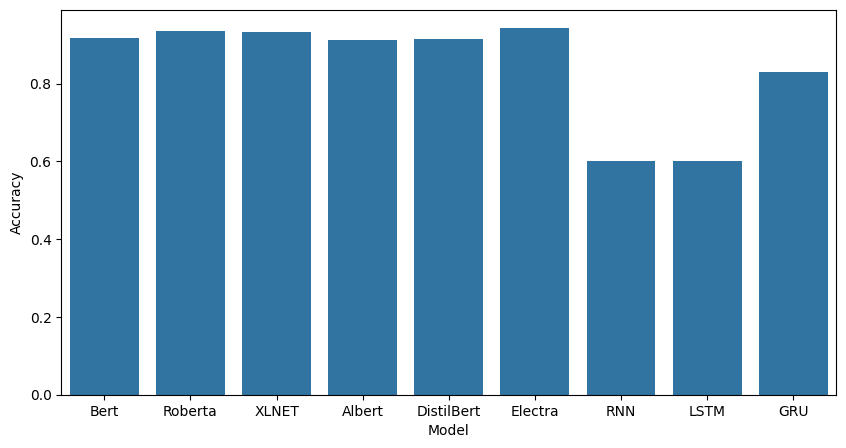

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=acc_df, x='Model', y='Accuracy', ax=ax)

## New Dataset- Amazon_Reviews_for_Sentiment_Analysis_fine_grained_5_classes


In [28]:
reviews=load_dataset('yassiracharki/Amazon_Reviews_for_Sentiment_Analysis_fine_grained_5_classes')

In [29]:
reviews

DatasetDict({
    train: Dataset({
        features: ['class_index', 'review_title', 'review_text'],
        num_rows: 3000000
    })
    test: Dataset({
        features: ['class_index', 'review_title', 'review_text'],
        num_rows: 650000
    })
})

In [30]:
reviews_train_val=reviews['train']
reviews_test=reviews['test']

In [31]:
reviews_test

Dataset({
    features: ['class_index', 'review_title', 'review_text'],
    num_rows: 650000
})

In [32]:
reviews_train_val

Dataset({
    features: ['class_index', 'review_title', 'review_text'],
    num_rows: 3000000
})

In [33]:
#split into train val 
reviews_train_val=reviews_train_val.train_test_split(test_size=0.2)

In [34]:
reviews_train_val

DatasetDict({
    train: Dataset({
        features: ['class_index', 'review_title', 'review_text'],
        num_rows: 2400000
    })
    test: Dataset({
        features: ['class_index', 'review_title', 'review_text'],
        num_rows: 600000
    })
})

In [35]:
reviews_train=reviews_train_val['train']
reviews_val=reviews_train_val['test']

In [36]:
reviews_train

Dataset({
    features: ['class_index', 'review_title', 'review_text'],
    num_rows: 2400000
})

In [37]:
reviews_val

Dataset({
    features: ['class_index', 'review_title', 'review_text'],
    num_rows: 600000
})

In [38]:
#function to tokenize 
def change_to_string(data):
    data['review_title']=[str(x) if x is not None else "No Title" for x in data['review_title']]
    data['review_text']=[str(x) if x is not None else "No Review" for x in data['review_text']]

    return data
    
    
    


def tokenize(data,tokenizer):
    return tokenizer(data['review_title'],
                     data['review_text'],
                     truncation=True,
                     padding='max_length',
                     max_length=128)

In [39]:
distilled_bert_tokenizer=AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

In [40]:
distilled_bert_tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [41]:
reviews_train=reviews_train.map(change_to_string,batched=True)

Map: 100%|██████████| 2400000/2400000 [00:38<00:00, 62686.06 examples/s]


In [42]:
reviews_val=reviews_val.map(change_to_string,batched=True)

Map: 100%|██████████| 600000/600000 [00:10<00:00, 58786.13 examples/s]


In [43]:
reviews_val.data

MemoryMappedTable
class_index: int64
review_title: string
review_text: string
----
class_index: [[3,1,3,5,3,...,3,5,3,2,1],[1,4,4,1,4,...,5,1,2,1,3],...,[3,1,1,5,1,...,4,4,3,3,3],[3,3,1,1,4,...,4,3,3,3,3]]
review_title: [["20th century Asian history","Get them for free from Bose","A bit flimsy and the dough does stick.","SHolmes Fan","3 out of 5",...,"i hate this toy","Great Dual Alarm Clock Radio","Black Notice","Airpot","Great movie, HORRIBLE BLU-RAY DISC"],["Only if you want a disposable one","Something new.","Pretty good","Simply wretched!","Long awaited, well worth it...",...,"Wonderful Natural Remedy to ease sinusitis!","They DO NOT LAST!","Not too great","Damaged Goods","Insult to the movie tombstone"],...,["Another one damaged by shipping","Doesn't work with almost ALL computers","Junk!","I Really LIke This This Book","don't waste your time",...,"addleman Seat","Close to perfect for these things","Good but gloopy","Helpful? Reference, yes. Teaching/learning, no.","Look Out For 

In [44]:
#change to labels
reviews_train=reviews_train.rename_column('class_index','label')
reviews_val=reviews_val.rename_column('class_index','label')
reviews_test=reviews_test.rename_column('class_index','label')

In [45]:
reviews_val

Dataset({
    features: ['label', 'review_title', 'review_text'],
    num_rows: 600000
})

In [48]:
dbert_tokenized_train_data=reviews_train.map(partial(tokenize,tokenizer=distilled_bert_tokenizer),batched=True)
dbert_tokenized_val_data=reviews_val.map(partial(tokenize,tokenizer=distilled_bert_tokenizer),batched=True)

Map: 100%|██████████| 600000/600000 [01:30<00:00, 6658.87 examples/s]


In [49]:
distilled_bert_tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [50]:
# Check the first tokenized example
sample = dbert_tokenized_train_data[0]
print("Keys in tokenized data:", sample.keys())
print("Input IDs length:", len(sample["input_ids"]))
print("Attention mask length:", len(sample["attention_mask"]))
print("Token type IDs length:", len(sample.get("token_type_ids", [])))  # Only for BERT-like models
print("Label:", sample["label"])

Keys in tokenized data: dict_keys(['label', 'review_title', 'review_text', 'input_ids', 'attention_mask'])
Input IDs length: 128
Attention mask length: 128
Token type IDs length: 0
Label: 5


In [51]:
dbert_tokenized_train_data.data

MemoryMappedTable
label: int64
review_title: string
review_text: string
input_ids: list<item: int32>
  child 0, item: int32
attention_mask: list<item: int8>
  child 0, item: int8
----
label: [[5,2,3,1,3,...,2,3,4,3,3],[3,4,5,3,5,...,3,5,1,2,4],...,[3,4,5,3,3,...,1,4,5,4,5],[1,1,2,2,4,...,5,5,2,4,5]]
review_title: [["excellent product","This is a cheap keyboard and its made that way","Not as expected.","This book is a definite New-Age point of view.","Visitations",...,"Didn't do anything for me.","Sometimes they work and sometimes they don't","NOT THE FIRST, NOT THE SECOND, BUT GOOD","The first, not the best","Detroit Love"],["Not what I expected","READ THIS REVIEW!","Another great book by Joyce Meyer!","You Must read My Review","WOW!",...,"The famous mistake of a tower.","Finally! Comfort and practical","Absolute rubbish","Only Amazon.com Purchase I ever returned","I like it"],...,["Good, but not great","Entertaining","nano","How to write a Gomez song","Very small, cannot be used on st

In [55]:
dbert_model=create_model('distilbert/distilbert-base-uncased',num_labels=5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
dbert_model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}

In [114]:
# #remove token type one
# bert_tokenized_train_data=bert_tokenized_train_data.remove_columns(['token_type_ids'])
# bert_tokenized_val_data=bert_tokenized_val_data.remove_columns(['token_type_ids'])

In [57]:
dbert_tokenized_train_data = dbert_tokenized_train_data.map(lambda x: {"label": x["label"]-1})

dbert_tokenized_val_data = dbert_tokenized_val_data.map(lambda x: {"label": x["label"]-1})



Map: 100%|██████████| 600000/600000 [00:36<00:00, 16335.83 examples/s]


In [58]:
set(dbert_tokenized_val_data['label'])

{0, 1, 2, 3, 4}

In [75]:
data_collator=DataCollatorWithPadding(tokenizer=distilled_bert_tokenizer,pad_to_multiple_of=8)
res=train_model(distilled_bert_tokenizer,dbert_model,dbert_tokenized_train_data,dbert_tokenized_val_data,learning_rate=lr,epochs=10,
                # run_name='DistilledBert',
                data_collator=data_collator)

setting training arguments
Setting up the trainer....
move to cuda
True
Training started


/tmp/ipykernel_12638/4224854880.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy
1,0.613500,0.973408,0.624690
2,0.745900,0.829046,0.642483
3,0.718300,0.842257,0.640160
4,0.692400,0.869971,0.639007
5,0.667600,0.877341,0.636570
6,0.643200,0.891006,0.634143
7,0.620100,0.937614,0.628990
8,0.598100,0.964792,0.628108
9,0.578400,0.981911,0.625595
10,0.561300,0.995959,0.624348


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [76]:
res

(<transformers.trainer.Trainer at 0x7f1a915a2e50>,
 {'eval_loss': 0.8290456533432007,
  'eval_accuracy': 0.6424833333333333,
  'eval_runtime': 352.7352,
  'eval_samples_per_second': 1700.992,
  'eval_steps_per_second': 53.156,
  'epoch': 10.0})

In [77]:
distilbert_trainer=res[0]

In [78]:
#convert test data review to string,just in case
reviews_test=reviews_test.map(change_to_string,batched=True)

In [79]:
#tokenize test data
dbert_tokenized_test_data=reviews_test.map(partial(tokenize,tokenizer=distilled_bert_tokenizer),batched=True)

#make labels 0 index
dbert_tokenized_test_data=dbert_tokenized_test_data.map(lambda x: {"label": x["label"]-1})

Map: 100%|██████████| 650000/650000 [00:48<00:00, 13415.33 examples/s]


In [81]:
dbert_tokenized_test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
dbert_model.to('cuda')
print("moved to cuda")



print("evaluating.....")



dbert_test_res=distilbert_trainer.evaluate(dbert_tokenized_test_data)

moved to cuda
evaluating.....


In [82]:
dbert_test_res

{'eval_loss': 0.8291406035423279,
 'eval_accuracy': 0.6424815384615384,
 'eval_runtime': 363.4842,
 'eval_samples_per_second': 1788.248,
 'eval_steps_per_second': 55.884,
 'epoch': 10.0}

#### Roberta for larger dataset

In [15]:
#load roberta tokenizer
roberta_tokenizer_2=AutoTokenizer.from_pretrained('FacebookAI/roberta-base')
roberta_tokenizer_2

RobertaTokenizerFast(name_or_path='FacebookAI/roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

In [25]:
#tokrnize the train and val df
roberta_tokenized_train_data=reviews_train.map(partial(tokenize,tokenizer=roberta_tokenizer_2),batched=True)
roberta_tokenized_val_data=reviews_val.map(partial(tokenize,tokenizer=roberta_tokenizer_2),batched=True)

Map: 100%|██████████| 600000/600000 [01:29<00:00, 6673.79 examples/s]


In [26]:
roberta_tokenized_val_data.data

MemoryMappedTable
label: int64
review_title: string
review_text: string
input_ids: list<item: int32>
  child 0, item: int32
attention_mask: list<item: int8>
  child 0, item: int8
----
label: [[4,2,4,2,4,...,1,4,5,4,2],[5,4,4,1,4,...,1,4,5,3,1],...,[4,2,3,5,3,...,1,5,3,1,2],[5,4,4,5,2,...,1,2,4,4,1]]
review_title: [["Safety Leash for Pedometer","Buggy but fun","Love my undies!!!!!!","horrid game =(","Truth in advertising",...,"Of interst only to the author's friends and family","Worth the $15!","I like my firest yoga dve","Sacred Companions: the gift of spiritual friendship & direction","Bought This CD Mainly For One Song"],["Not quite magic, and need some elbow grease, but does what it says...","This book was very knowledgable!","Tongue cleaner","horrible","This is a BIG compact net! WOW",...,"Useless in Canada.","Everything needed","Food steaming is the way to go","Good Primer","This book is Pants"],...,["good","nice WiFi; lousy compatibility; not worth upgrading","A different slice o

In [16]:
#load the model
roberta_model_2=create_model('FacebookAI/roberta-base',num_labels=5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
roberta_model_2.config.num_labels

5

In [35]:
#make the labels 0-index
roberta_tokenized_train_data = roberta_tokenized_train_data.map(lambda x: {"label": x["label"]-1})

roberta_tokenized_val_data = roberta_tokenized_val_data.map(lambda x: {"label": x["label"]-1})


Map: 100%|██████████| 600000/600000 [00:35<00:00, 16669.74 examples/s]


In [36]:
print(set(roberta_tokenized_train_data['label']))
print(set(roberta_tokenized_val_data['label']))
      

{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}


In [40]:
data_collator=DataCollatorWithPadding(tokenizer=roberta_tokenizer_2)
roberta_trainer,val_res=train_model(roberta_tokenizer_2,roberta_model_2,roberta_tokenized_train_data,roberta_tokenized_val_data,learning_rate=lr,
                                    epochs=10,run_name='RoBERTa',data_collator=data_collator)

setting training arguments
Setting up the trainer....
move to cuda
True


/tmp/ipykernel_3885/352122093.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Training started


Epoch,Training Loss,Validation Loss,Accuracy
1,0.821400,0.800067,0.653472
2,0.771400,0.793339,0.659042
3,0.743300,0.785434,0.662037
4,0.717400,0.793792,0.660605
5,0.692600,0.803194,0.660132
6,0.668400,0.827363,0.657800
7,0.645200,0.845383,0.656132
8,0.624300,0.856486,0.654717
9,0.605800,0.869739,0.652527
10,0.591800,0.886404,0.651422


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [42]:
val_res

{'eval_loss': 0.7854337692260742,
 'eval_accuracy': 0.6620366666666667,
 'eval_runtime': 586.3292,
 'eval_samples_per_second': 1023.316,
 'eval_steps_per_second': 31.979,
 'epoch': 10.0}

In [22]:


#tokenize test data
roberta_tokenized_test_data=reviews_test.map(partial(tokenize,tokenizer=roberta_tokenizer_2),batched=True)

#make labels 0 index
roberta_tokenized_test_data=roberta_tokenized_test_data.map(lambda x: {"label": x["label"]-1})

# roberta_tokenized_test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# roberta_model_2.to('cuda')
# print("moved to cuda")

# #load the best model
# roberta_best_model_2=AutoModelForSequenceClassification.from_pretrained('results/checkpoint-112500')
# print("loaded best model")

# print("evaluating.....")
# test_trainer=Trainer(model=roberta_best_model_2,
#                 tokenizer=roberta_tokenizer_2)


# roberta_test_res=test_trainer.evaluate(roberta_tokenized_test_data)



Map: 100%|██████████| 650000/650000 [00:40<00:00, 15859.82 examples/s]


In [24]:
print(set(roberta_tokenized_test_data['label']))

{0, 1, 2, 3, 4}


In [25]:
#load best model
roberta_best_model_2=AutoModelForSequenceClassification.from_pretrained('results/checkpoint-150000')
print(roberta_best_model_2.config)

RobertaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [31]:
#moveto cuda
roberta_best_model_2.to('cuda')
print("moved to cuda")

test_trainer=Trainer(model=roberta_best_model_2,
                     processing_class=roberta_tokenizer_2,compute_metrics=eval_metrics)


roberta_test_res=test_trainer.evaluate(roberta_tokenized_test_data)
                     

moved to cuda


In [32]:
roberta_test_res

{'eval_loss': 0.7945932745933533,
 'eval_model_preparation_time': 0.0068,
 'eval_accuracy': 0.6597876923076923,
 'eval_runtime': 1786.7356,
 'eval_samples_per_second': 363.792,
 'eval_steps_per_second': 45.474}

In [119]:
with open('./acc_dict.txt',"w") as f:
    for key, value in acc_dict.items():
        f.write(f"{key}: {value}\n")

#### Compare both models

In [83]:
acc_results={"Model":['DistilBert','Roberta'],
             "Accuracies":[dbert_test_res['eval_accuracy'],0.65]}

In [85]:
accuracy_df=pd.DataFrame(acc_results)

In [87]:
accuracy_df

,Model,Accuracies
0,DistilBert,0.642482
1,Roberta,0.650000


<Axes: xlabel='Model', ylabel='Accuracies'>

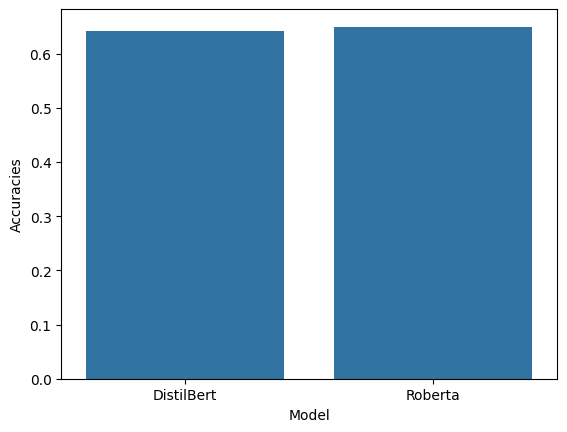

In [89]:
#plot

sns.barplot(accuracy_df,x="Model",y="Accuracies")

### Small Dataset

In [7]:
amazon_reviews_small=pd.read_csv('amazon_cells_labelled.txt',delimiter='\t',names=['Sentence','Class'],header=None)

In [8]:
train_small_df,val_small_df,test_small_df=split_train_test_val(amazon_reviews_small,'Class')

In [10]:
acc_dict_small={"Model":[],
          'Accuracy':[]}
def update_dict(model,acc):
    acc_dict_small["Model"].append(model)
    acc_dict_small['Accuracy'].append(acc)

    return acc_dict_small
    

In [ ]:
###

In [97]:
bert_tokenizer=AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

#tokenize train_df
train_small_df['Bert Tokenizer']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[0])
train_small_df['Bert Attention_Mask']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[1])

#tokenize val_df
val_small_df['Bert Tokenizer']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[0])
val_small_df['Bert Attention_Mask']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[1])

#create bert model
bert_model=create_model('google-bert/bert-base-uncased',num_labels=2)

#we will create the class of our dataset
bert_train_small_df=HuggingFaceDataset(train_small_df['Bert Tokenizer'],train_small_df['Bert Attention_Mask'],train_small_df['Class'])
bert_val_small_df=HuggingFaceDataset(val_small_df['Bert Tokenizer'],val_small_df['Bert Attention_Mask'],val_small_df['Class'])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
bert_model.config.num_labels

2

In [102]:
data_collator=DataCollatorWithPadding(bert_tokenizer)
bert_trainer,bert_res=train_model(bert_tokenizer,bert_model,bert_train_small_df,bert_val_small_df,learning_rate=lr,epochs=10,run_name="Bert",
                                 data_collator=data_collator)

setting training arguments
Setting up the trainer....
move to cuda
True


eval/accuracy,▅▁█▇▇▆▅▃▂▁▁██
eval/loss,▃▇▁▂▃▃▄▆▇▇█▁▁
eval/runtime,▁▁▃▄▅▁▆▆▅▆▅▅█
eval/samples_per_second,▆▆▄▃▃▆▁▁▂▂▂▃█
eval/steps_per_second,▆▆▄▃▃▆▁▁▂▂▂▃█
train/epoch,▁▁▁▁▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇█████
train/global_step,▁▁▁▁▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇█████
train/grad_norm,▁▂▄█▃▃▄▃▃▆▆▇▆
train/learning_rate,████▇▆▆▅▄▃▃▂▁
train/loss,█▆▄▂▅▅▄▃▃▂▂▁▁
eval/accuracy,0.64248


/tmp/ipykernel_12638/2605672323.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Training started


Epoch,Training Loss,Validation Loss,Accuracy
1,0.403800,0.374759,0.906667
2,0.152000,0.402620,0.906667
3,0.074000,0.420298,0.926667
4,0.033600,0.493469,0.906667
5,0.030600,0.478819,0.920000
6,0.021100,0.479655,0.926667
7,0.017900,0.510994,0.926667
8,0.011000,0.507010,0.920000
9,0.009800,0.520842,0.926667
10,0.008200,0.523285,0.926667


#### Test the Bert Model

In [103]:
#tokenize test data
test_small_df['Bert Tokenizer']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[0])
test_small_df['Bert Attention_Mask']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,bert_tokenizer)[1])


bert_test_small_df=HuggingFaceDataset(test_small_df['Bert Tokenizer'],test_small_df['Bert Attention_Mask'],test_small_df['Class'])

In [104]:
#evaluate
bert_test_res_small=bert_trainer.evaluate(bert_test_small_df)

In [108]:
bert_test_res_small

{'eval_loss': 0.2822708487510681,
 'eval_accuracy': 0.9266666666666666,
 'eval_runtime': 0.8529,
 'eval_samples_per_second': 175.872,
 'eval_steps_per_second': 44.554,
 'epoch': 10.0}

In [117]:
update_dict("Bert",bert_test_res_small['eval_accuracy'])

{'Model': ['Bert'], 'Accuracy': [0.9266666666666666]}

#### Roberta Model

In [15]:
#load tokenizer
roberta_tokenizer=AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

##tokenize train_df
train_small_df['Roberta Tokenizer']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[0])
train_small_df['Roberta Attention_Mask']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[1])

#tokenize val_df
val_small_df['Roberta Tokenizer']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[0])
val_small_df['Roberta Attention_Mask']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[1])


#create roberta model
roberta_model=create_model('FacebookAI/roberta-base',num_labels=2)


#create the class of our dataset
roberta_train_small_df=HuggingFaceDataset(train_small_df['Roberta Tokenizer'],train_small_df['Roberta Attention_Mask'],train_small_df['Class'])
roberta_val_small_df=HuggingFaceDataset(val_small_df['Roberta Tokenizer'],val_small_df['Roberta Attention_Mask'],val_small_df['Class'])


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
data_collator=DataCollatorWithPadding(roberta_tokenizer)
roberta_trainer,roberta_res=train_model(roberta_tokenizer,roberta_model,roberta_train_small_df,roberta_val_small_df,learning_rate=lr,epochs=10,
                                        run_name="Roberta",data_collator=data_collator)

setting training arguments
Setting up the trainer....
move to cuda
True


/tmp/ipykernel_15847/2605672323.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Training started


/tmp/ipykernel_15847/2168056350.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_mask[idx],dtype=torch.long),


Epoch,Training Loss,Validation Loss,Accuracy
1,0.514300,0.363093,0.933333
2,0.257700,0.405656,0.926667
3,0.214800,0.611728,0.906667
4,0.115000,0.484678,0.920000
5,0.040300,0.587915,0.926667
6,0.013300,0.783616,0.900000
7,0.040100,0.802131,0.900000
8,0.017500,0.755294,0.900000
9,0.021300,0.827626,0.893333
10,0.021400,0.827826,0.900000


/tmp/ipykernel_15847/2168056350.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_mask[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:20: UserWarning: To copy construct from a tensor,

In [17]:
roberta_res

{'eval_loss': 0.36309289932250977,
 'eval_accuracy': 0.9333333333333333,
 'eval_runtime': 0.7867,
 'eval_samples_per_second': 190.658,
 'eval_steps_per_second': 48.3,
 'epoch': 10.0}

In [18]:
roberta_trainer

#### test the model

In [20]:

#tokenize test data
test_small_df['Roberta Tokenizer']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[0])
test_small_df['Roberta Attention_Mask']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,roberta_tokenizer)[1])


roberta_test_small_df=HuggingFaceDataset(test_small_df['Roberta Tokenizer'],test_small_df['Roberta Attention_Mask'],test_small_df['Class'])

roberta_test_res=roberta_trainer.evaluate(roberta_test_small_df)
print(roberta_test_res)

# #load best model
# best_roberta_model=AutoModelForSequenceClassification.from_pretrained('small_data/results/checkpoint-525')

# test_trainer=Trainer(model=best_roberta_model,
#                      processing_class=roberta_tokenizer)

# roberta_test_small_res=test_trainer.evaluate(roberta_test_small_df)

/tmp/ipykernel_15847/2168056350.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_mask[idx],dtype=torch.long),


{'eval_loss': 0.2804804742336273, 'eval_accuracy': 0.9466666666666667, 'eval_runtime': 0.8224, 'eval_samples_per_second': 182.398, 'eval_steps_per_second': 46.207, 'epoch': 10.0}


In [23]:
update_dict("Roberta",roberta_test_res['eval_accuracy'])

{'Model': ['Bert', 'Roberta'],
 'Accuracy': [0.9266666666666666, 0.9466666666666667]}

### Albert

In [24]:
albert_tokenizer=AutoTokenizer.from_pretrained('albert-base-v2')

#tokenize train_df
train_small_df['Albert Tokenizer']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[0])
train_small_df['Albert Attention_Mask']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[1])

#tokenize val_df
val_small_df['Albert Tokenizer']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[0])
val_small_df['Albert Attention_Mask']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[1])

#create bert model
albert_model=create_model('albert-base-v2',num_labels=2)

#we will create the class of our dataset
albert_train_small_df=HuggingFaceDataset(train_small_df['Albert Tokenizer'],train_small_df['Albert Attention_Mask'],train_small_df['Class'])
albert_val_small_df=HuggingFaceDataset(val_small_df['Albert Tokenizer'],val_small_df['Albert Attention_Mask'],val_small_df['Class'])


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
data_collator=DataCollatorWithPadding(albert_tokenizer)
albert_trainer,albert_res=train_model(albert_tokenizer,albert_model,albert_train_small_df,albert_val_small_df,learning_rate=lr,epochs=10,
                                        run_name="Albert",data_collator=data_collator)

setting training arguments
Setting up the trainer....
move to cuda
True


eval/accuracy,▆▅▃▅▅▂▂▂▁▂▆█
eval/loss,▂▃▅▄▅▇█▇██▂▁
eval/runtime,▁▅▅▃▆▁▅▅▄▃▆█
eval/samples_per_second,▇▄▄▆▃█▄▄▅▆▃▁
eval/steps_per_second,▇▄▄▆▃█▄▄▅▆▃▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇█████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇█████
train/grad_norm,▁█▁▁▁▁▁▁▁▁
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▄▄▂▁▁▁▁▁▁
eval/accuracy,0.94667


/tmp/ipykernel_15847/2605672323.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,


Training started


/tmp/ipykernel_15847/2168056350.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_mask[idx],dtype=torch.long),


Epoch,Training Loss,Validation Loss,Accuracy
1,0.393100,0.540367,0.913333
2,0.249200,0.389675,0.926667
3,0.117900,0.480966,0.933333
4,0.082600,0.570745,0.920000
5,0.057100,0.608569,0.920000
6,0.025300,0.614811,0.920000
7,0.016900,0.621400,0.920000
8,0.010500,0.642575,0.920000
9,0.008100,0.648912,0.920000
10,0.006200,0.649712,0.920000


/tmp/ipykernel_15847/2168056350.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_mask[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
/tmp/ipykernel_15847/2168056350.py:20: UserWarning: To copy construct from a tensor,

In [30]:
#tokenize test data
test_small_df['Albert Tokenizer']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[0])
test_small_df['Albert Attention_Mask']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,albert_tokenizer)[1])


albert_test_small_df=HuggingFaceDataset(test_small_df['Albert Tokenizer'],test_small_df['Albert Attention_Mask'],test_small_df['Class'])

albert_test_res=albert_trainer.evaluate(albert_test_small_df)
print(albert_test_res)

{'eval_loss': 0.4279579818248749, 'eval_accuracy': 0.9266666666666666, 'eval_runtime': 1.2113, 'eval_samples_per_second': 123.832, 'eval_steps_per_second': 31.371, 'epoch': 10.0}


In [32]:
update_dict("Albert",albert_test_res['eval_accuracy'])

{'Model': ['Bert', 'Roberta', 'Albert'],
 'Accuracy': [0.9266666666666666, 0.9466666666666667, 0.9266666666666666]}

### DisltilBert

In [33]:
#load tokenizer
distilbert_tokenizer=AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

#tokenize traindf
train_small_df['DistilBert Tokenizer']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[0])
train_small_df['DistilBert Attention_Mask']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[1])

#tokenize valdf
val_small_df['DistilBert Tokenizer']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[0])
val_small_df['DistilBert Attention_Mask']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[1])



#create model
distilbert_model=create_model('distilbert/distilbert-base-uncased',num_labels=2)

#create instance from data classes
distilbert_train_small_df=HuggingFaceDataset(train_small_df['DistilBert Tokenizer'],train_small_df['DistilBert Attention_Mask'],train_small_df['Class'])
distilbert_val_small_df=HuggingFaceDataset(val_small_df['DistilBert Tokenizer'],val_small_df['DistilBert Attention_Mask'],val_small_df['Class'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
#train
data_collator=DataCollatorWithPadding(distilbert_tokenizer)
dbert_small_trainer,dbert_small_res=train_model(distilbert_tokenizer,distilbert_model,distilbert_train_small_df,
                                                distilbert_val_small_df,learning_rate=lr,epochs=10,run_name="DistilBert",data_collator=data_collator)

setting training arguments
Setting up the trainer....
move to cuda
True


eval/accuracy,▁▆█▃▃▃▃▃▃▃▆▆▆
eval/loss,▅▁▃▆▇▇▇███▁▂▂
eval/runtime,▁▁▁▁█▁▁▃▄▁▁▃▅
eval/samples_per_second,██▇█▁██▆▅▇█▆▃
eval/steps_per_second,██▇█▁██▆▅▇█▆▃
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██████
train/grad_norm,▅█▁▁▁▁▁▁▁▁
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▅▃▂▂▁▁▁▁▁
eval/accuracy,0.92667


Training started


Epoch,Training Loss,Validation Loss,Accuracy
1,0.436000,0.355628,0.900000
2,0.184500,0.317041,0.926667
3,0.108700,0.453195,0.900000
4,0.064700,0.471001,0.913333
5,0.040900,0.506673,0.906667
6,0.018700,0.530916,0.913333
7,0.013800,0.549626,0.913333
8,0.012000,0.560677,0.913333
9,0.010400,0.569720,0.906667
10,0.010900,0.574439,0.913333


In [37]:
#tokenize test data
test_small_df['DistilBert Tokenizer']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[0])
test_small_df['DistilBert Attention_Mask']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,distilbert_tokenizer)[1])

distilbert_test_small_df=HuggingFaceDataset(test_small_df['DistilBert Tokenizer'],test_small_df['DistilBert Attention_Mask'],test_small_df['Class'])

dbert_test_res=dbert_small_trainer.evaluate(distilbert_test_small_df)
print(dbert_test_res)

{'eval_loss': 0.35724058747291565, 'eval_accuracy': 0.8933333333333333, 'eval_runtime': 0.5003, 'eval_samples_per_second': 299.828, 'eval_steps_per_second': 75.956, 'epoch': 10.0}


In [38]:
update_dict("DistilBert",dbert_test_res['eval_accuracy'])

{'Model': ['Bert', 'Roberta', 'Albert', 'DistilBert'],
 'Accuracy': [0.9266666666666666,
  0.9466666666666667,
  0.9266666666666666,
  0.8933333333333333]}

### XLNET

In [40]:
#load tokenizer
xlnet_tokenizer=AutoTokenizer.from_pretrained('xlnet/xlnet-base-cased')

##tokenize train_df
train_small_df['XLNet Tokenizer']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[0])
train_small_df['XLNet Attention_Mask']=train_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[1])

#tokenize val_df
val_small_df['XLNet Tokenizer']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[0])
val_small_df['XLNet Attention_Mask']=val_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[1])


#create roberta model
xlnet_model=create_model('xlnet/xlnet-base-cased',num_labels=2)


#create the class of our dataset
xlnet_train_small_df=HuggingFaceDataset(train_small_df['XLNet Tokenizer'],train_small_df['XLNet Attention_Mask'],train_small_df['Class'])
xlnet_val_small_df=HuggingFaceDataset(val_small_df['XLNet Tokenizer'],val_small_df['XLNet Attention_Mask'],val_small_df['Class'])


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
data_collator=DataCollatorWithPadding(xlnet_tokenizer)
xlnet_small_trainer,xlnet_small_res=train_model(xlnet_tokenizer,xlnet_model,xlnet_train_small_df,
                                                xlnet_val_small_df,learning_rate=lr,epochs=10,run_name="XLNET",data_collator=data_collator)

setting training arguments
Setting up the trainer....
move to cuda
True


eval/accuracy,▁▇▇▆▃▅▂███▁
eval/loss,▁▄▃▄▆▆█▅▅▅▁
eval/runtime,█▁▄▁▁▁▁▁▂▁▃
eval/samples_per_second,▁█▅█████▇▇▆
eval/steps_per_second,▁█▅█████▇▇▆
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/grad_norm,▄▃█▁▁▁▁▁▁▁
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▅▄▂▂▂▁▂▁▁
eval/accuracy,0.89333


Training started


Epoch,Training Loss,Validation Loss,Accuracy
1,0.324500,0.511418,0.913333
2,0.291000,0.542039,0.926667
3,0.202200,0.463358,0.920000
4,0.110100,0.639185,0.926667
5,0.050000,0.629335,0.926667
6,0.065100,0.624401,0.926667
7,0.034000,0.612341,0.933333
8,0.029400,0.580496,0.940000
9,0.039200,0.628461,0.926667
10,0.032400,0.589297,0.933333


In [43]:
#tokenize test data
test_small_df['XLNET Tokenizer']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[0])
test_small_df['XLNET Attention_Mask']=test_small_df['Sentence'].apply(lambda x: tokenize_using_hf(x,xlnet_tokenizer)[1])

xlnet_test_small_df=HuggingFaceDataset(test_small_df['XLNET Tokenizer'],test_small_df['XLNET Attention_Mask'],test_small_df['Class'])

xlnet_test_res=xlnet_small_trainer.evaluate(xlnet_test_small_df)
print(xlnet_small_res)

{'eval_loss': 0.4633583724498749, 'eval_accuracy': 0.92, 'eval_runtime': 4.1743, 'eval_samples_per_second': 35.934, 'eval_steps_per_second': 9.103, 'epoch': 10.0}


In [44]:
update_dict("XLNET",xlnet_small_res['eval_accuracy'])

{'Model': ['Bert', 'Roberta', 'Albert', 'DistilBert', 'XLNET'],
 'Accuracy': [0.9266666666666666,
  0.9466666666666667,
  0.9266666666666666,
  0.8933333333333333,
  0.92]}

In [46]:
with open('./small_acc_dict.txt', "w") as f:
    for key,value in acc_dict_small.items():
        f.write(f"{key} : {value}")

### Using classical deep learning methods

In [9]:
#preprocess the data
train_small_df['Sentence']=train_small_df['Sentence'].apply(lambda x:preprocess_text(x))
val_small_df['Sentence']=val_small_df['Sentence'].apply(lambda x:preprocess_text(x))
test_small_df['Sentence']=test_small_df['Sentence'].apply(lambda x:preprocess_text(x))

In [10]:
#tokrnize text
train_small_df['Tokenized Text']=train_small_df['Sentence'].apply(lambda x: tokenize_text(x))
val_small_df['Tokenized Text']=val_small_df['Sentence'].apply(lambda x: tokenize_text(x))
test_small_df['Tokenized Text']=test_small_df['Sentence'].apply(lambda x: tokenize_text(x))

In [49]:
train_small_df['Vectorized Tokens Pretrained']=train_small_df['Tokenized Text'].apply(lambda x: vectorize_word2vec_pretrained(x))
val_small_df['Vectorized Tokens Pretrained']=val_small_df['Tokenized Text'].apply(lambda x: vectorize_word2vec_pretrained(x))
test_small_df['Vectorized Tokens Pretrained']=test_small_df['Tokenized Text'].apply(lambda x: vectorize_word2vec_pretrained(x))



train_small_df=train_small_df[train_small_df['Vectorized Tokens Pretrained'].apply(lambda x: len(x) > 0)]
val_small_df=val_small_df[val_small_df['Vectorized Tokens Pretrained'].apply(lambda x: len(x) > 0)]
test_small_df=test_small_df[test_small_df['Vectorized Tokens Pretrained'].apply(lambda x: len(x) > 0)]

In [50]:
val_small_df.head()

,Sentence,Class,Tokenized Text,Vectorized Tokens Pretrained
0,worst software ever used if i could give this ...,0,"[worst, software, ever, used, could, give, zer...","[[0.16601562, -0.08203125, 0.45117188, 0.12255..."
1,bluetooth does not work phone locks up screens...,0,"[bluetooth, work, phone, locks, screens, flash...","[[-0.107910156, -0.23046875, -0.21484375, 0.37..."
2,im still infatuated with this phone,1,"[im, still, infatuated, phone]","[[-0.036621094, 0.014526367, 0.03515625, 0.230..."
3,i have this phone and it is a thorn in my side...,0,"[phone, thorn, side, really, abhor]","[[-0.014465332, -0.12792969, -0.115722656, -0...."
4,it doesnt work in europe or asia,0,"[doesnt, work, europe, asia]","[[-0.075683594, 0.033691406, -0.064941406, 0.1..."


In [51]:
#create dataloaders
train_loader_small=DataLoader(Word2VecData(train_small_df),batch_size=16,collate_fn=collate_fn,num_workers=0)
val_loader_small=DataLoader(Word2VecData(val_small_df),batch_size=16,collate_fn=collate_fn)
test_loader_small=DataLoader(Word2VecData(test_small_df),batch_size=16,collate_fn=collate_fn)

#### RNN

In [52]:
word2vec_pt_model=WordToVecRNNPT(input_size,hidden_size,output_size)
print(word2vec_pt_model)

WordToVecRNNPT(
  (rnn): RNN(300, 128)
  (hidden_to_op): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [53]:
#train the network
train_network(word2vec_pt_model,train_loader_small,val_loader_small,epochs,lr,criterion)

epoch 5:  training loss : 0.694806157187982, val loss: 0.7002431154251099
epoch 10:  training loss : 0.6947851749983701, val loss: 0.7002291262149811
epoch 15:  training loss : 0.6947641995820132, val loss: 0.7002150893211365
epoch 20:  training loss : 0.6947432458400726, val loss: 0.7002010524272919
epoch 25:  training loss : 0.6947223015806891, val loss: 0.7001870632171631
epoch 30:  training loss : 0.6947013613852587, val loss: 0.7001730382442475
epoch 35:  training loss : 0.6946804171258752, val loss: 0.7001590609550477
epoch 40:  training loss : 0.6946594999595122, val loss: 0.7001450777053833
epoch 45:  training loss : 0.6946385882117532, val loss: 0.700131106376648
epoch 50:  training loss : 0.6946176845919002, val loss: 0.700117152929306
epoch 55:  training loss : 0.6945967850360003, val loss: 0.7001031637191772
epoch 60:  training loss : 0.6945759152824228, val loss: 0.7000892102718353
epoch 65:  training loss : 0.6945550374009393, val loss: 0.7000752687454224
epoch 70:  train

In [54]:
#test
rnn_test_acc=test_model(word2vec_pt_model,test_loader_small)
print(f"{rnn_test_acc:.2f}")

0.41


#### LSTM

In [55]:
lstm_model=LSTMModel(input_size,hidden_size,output_size)
print(lstm_model)

LSTMModel(
  (LSTM): LSTM(300, 128)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)


In [56]:
#train the lstm model 
train_network(lstm_model,train_loader_small,val_loader_small,epochs,lr,criterion)

epoch 5:  training loss : 0.6937635134566914, val loss: 0.6941172420978546
epoch 10:  training loss : 0.6937615559859709, val loss: 0.6941155254840851
epoch 15:  training loss : 0.6937596147710626, val loss: 0.6941137909889221
epoch 20:  training loss : 0.6937576708468524, val loss: 0.6941121041774749
epoch 25:  training loss : 0.6937557147307829, val loss: 0.6941103875637055
epoch 30:  training loss : 0.693753791126338, val loss: 0.6941086828708649
epoch 35:  training loss : 0.6937518323009665, val loss: 0.6941069483757019
epoch 40:  training loss : 0.6937498870221052, val loss: 0.6941052496433258
epoch 45:  training loss : 0.6937479309060357, val loss: 0.6941035449504852
epoch 50:  training loss : 0.6937459937550805, val loss: 0.6941018283367157
epoch 55:  training loss : 0.6937440457669172, val loss: 0.6941001117229462
epoch 60:  training loss : 0.6937420977787538, val loss: 0.6940983951091766
epoch 65:  training loss : 0.6937401646917517, val loss: 0.694096690416336
epoch 70:  trai

In [59]:
test_acc=test_model(lstm_model,test_loader_small)

In [60]:
test_acc

0.4563758373260498

In [62]:
#create an instnace of the model
gru_model=GRUModel(input_size,hidden_size,output_size)


#train the model
train_network(gru_model,train_loader_small,val_loader_small,epochs,lr,criterion)

epoch 5:  training loss : 0.6985453827814623, val loss: 0.696148031949997
epoch 10:  training loss : 0.6985357593406331, val loss: 0.696139395236969
epoch 15:  training loss : 0.6985261778939854, val loss: 0.6961307287216186
epoch 20:  training loss : 0.6985165571624582, val loss: 0.6961220860481262
epoch 25:  training loss : 0.6985069621693004, val loss: 0.6961134254932404
epoch 30:  training loss : 0.6984973644668405, val loss: 0.696104770898819
epoch 35:  training loss : 0.6984877748922869, val loss: 0.69609614610672
epoch 40:  training loss : 0.698478178544478, val loss: 0.6960875213146209
epoch 45:  training loss : 0.6984685903245752, val loss: 0.6960788786411285
epoch 50:  training loss : 0.6984590251337398, val loss: 0.6960702419281006
epoch 55:  training loss : 0.6984494409777902, val loss: 0.696061646938324
epoch 60:  training loss : 0.6984398771416057, val loss: 0.696053010225296
epoch 65:  training loss : 0.6984302984042601, val loss: 0.696044385433197
epoch 70:  training lo

In [64]:
gru_test_acc=test_model(gru_model,test_loader_small)
print(f"{gru_test_acc:.2f}")

0.50


In [70]:
with open('small_acc_dict.txt', 'r') as f:
    data = f.read()

    model_part = data.split("Accuracy")[0].replace("Model :", "").strip()
    acc_part = data.split("Accuracy :")[1].strip()

    acc_small_dict = {
        "Model": eval(model_part),
        "Accuracy": eval(acc_part)
    }

    

In [72]:
acc_small_dict['Model'].extend(["RNN","LSTM","GRU"])
acc_small_dict['Accuracy'].extend([rnn_test_acc,test_acc,gru_test_acc])

In [74]:
acc_small_df=pd.DataFrame(acc_small_dict)

<Axes: xlabel='Model', ylabel='Accuracy'>

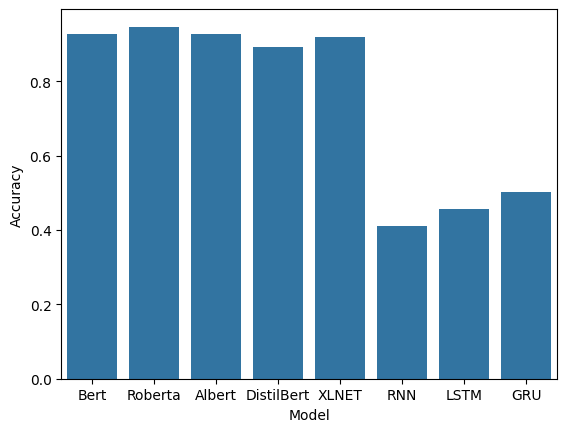

In [76]:
sns.barplot(acc_small_dict,x="Model",y="Accuracy")